In [15]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')
from apnet.model import APNet
from apnet.layers import PrototypeLayer, WeightedSum
from apnet.datasets import MedleySolosDb, GoogleSpeechCommands

from dcase_models.data.datasets import UrbanSound8k
from dcase_models.data.features import MelSpectrogram
from dcase_models.util.files import load_json, mkdir_if_not_exists
from dcase_models.util.files import load_pickle, save_pickle
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.scaler import Scaler
from dcase_models.util.data import evaluation_setup

from dcase_models.util.files import mkdir_if_not_exists, list_wav_files

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
datasets = {
    'UrbanSound8k': UrbanSound8k,
    'MedleySolosDb': MedleySolosDb,
    'GoogleSpeechCommands': GoogleSpeechCommands,    
}

In [29]:
model_name = 'APNet'
features_name = 'MelSpectrogram'

dataset_name = 'MedleySolosDb'  # 'UrbanSound8k' 'GoogleSpeechCommands'  'MedleySolosDb'
fold_name = 'test' # 'fold10' 'test'

In [30]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models']['APNet']

In [31]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = datasets[dataset_name](dataset_path)
dataset.check_if_downloaded()

True

In [32]:
features = MelSpectrogram(**params_features)
print(features.get_shape())
if not features.check_if_extracted(dataset):
    features.extract(dataset)

(1, 128, 256)


In [33]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum
    },
    **params['models']['APNet']['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

(40, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 256)     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 32, 64, 48), 116544      input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 32, 64, 48)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 40, 64)       3932160     features[0][0]                   
__________________________________________________________________________________________________
s

In [34]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen_train = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=True, train=True, scaler=scaler
)

if dataset_name in ['MedleySolosDb', 'GoogleSpeechCommands']:
    data_gen_train.audio_file_list = data_gen_train.audio_file_list[:int(len( data_gen_train.audio_file_list)/3)]

In [35]:
X_train, Y_train = data_gen_train.get_data()
print(X_train.shape, Y_train.shape)

(1947, 128, 256) (1947, 8)


In [36]:
#model_container.prototypes = load_pickle(os.path.join(exp_folder, 'prototypes.pickle'))

convert_audio_params = {
    'sr': params_features['sr'],
    'scaler': scaler,
    'mel_basis': features.mel_basis,
    'audio_hop': params_features['audio_hop'],
    'audio_win': params_features['audio_win']
}

model_container.get_prototypes(X_train, convert_audio_params=convert_audio_params)

Getting prototypes (spectrograms)...
Done!
Converting to audio...
[############################################################] 40/40
Done!


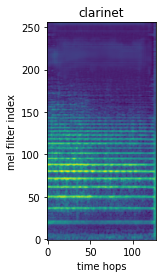

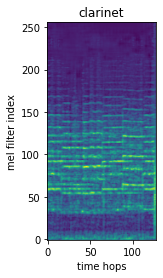

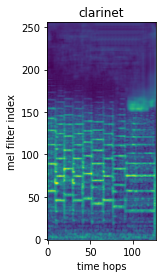

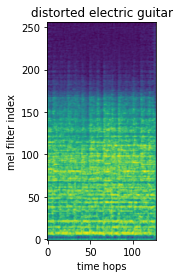

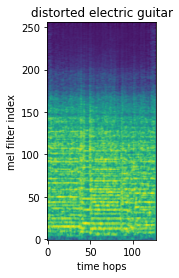

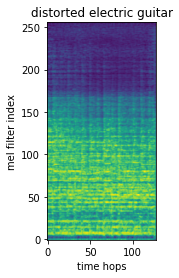

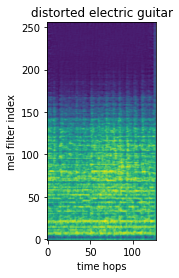

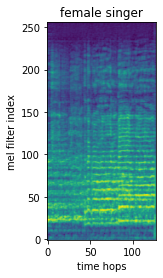

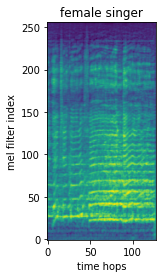

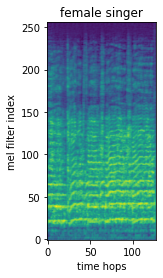

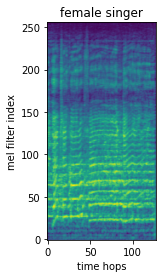

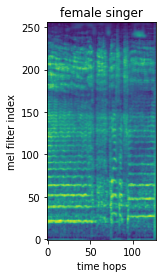

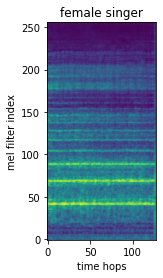

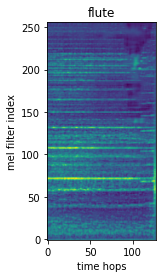

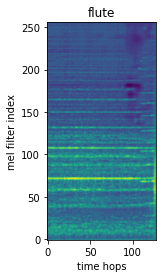

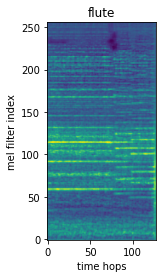

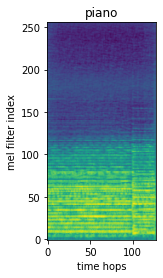

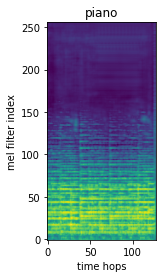

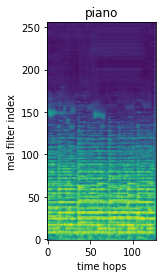

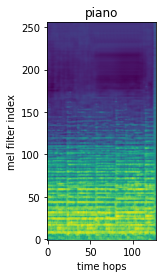

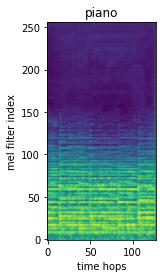

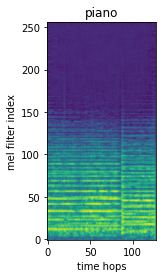

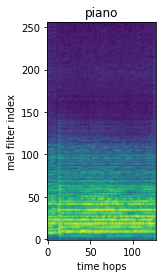

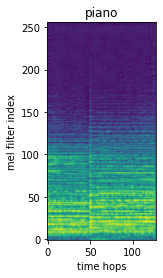

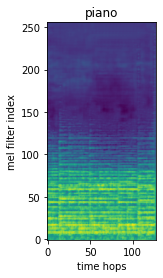

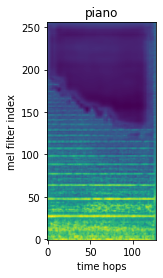

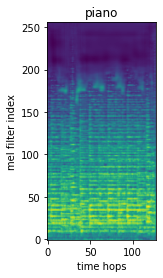

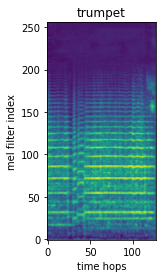

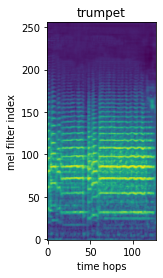

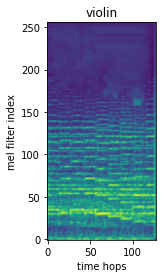

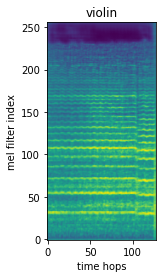

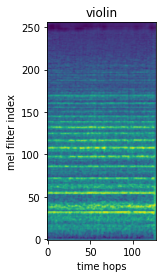

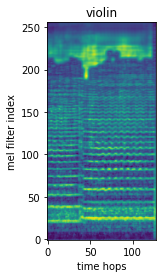

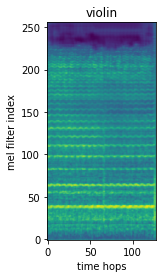

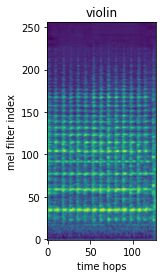

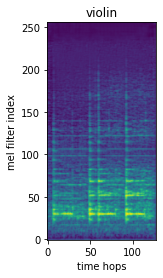

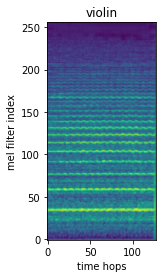

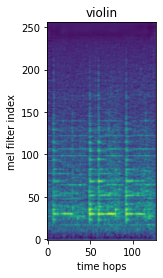

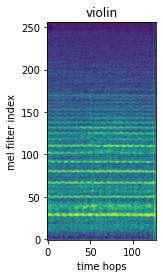

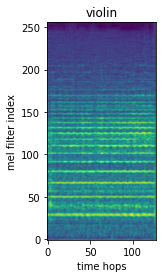

In [37]:
model_container.prototypes.sort()

prototypes_folder = os.path.join('../prototypes', dataset_name)
mkdir_if_not_exists(prototypes_folder, parents=True)

for j, audio_dict in enumerate(model_container.prototypes.audios):
    class_name = dataset.label_list[model_container.prototypes.classes[j]]
    if dataset_name == 'GoogleSpeechCommands':
        file_name = '%03d_%s.wav' % (j, class_name)
    else:
        file_name = '%02d_%s.wav' % (j, class_name)
    file_path = os.path.join(prototypes_folder, file_name)
    sf.write(file_path, audio_dict['data']/np.amax(audio_dict['data']), audio_dict['sr'])
    
    mel_spec = model_container.prototypes.mel_spectrograms[j]
    plt.figure()
    plt.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
    plt.xlabel('time hops')
    plt.ylabel('mel filter index')
    file_path_mel = file_path.replace('.wav', '.png')
    plt.title(class_name)
    plt.savefig(file_path_mel, dpi=300, bbox_inches='tight', pad_inches=0)